In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Jaccard'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

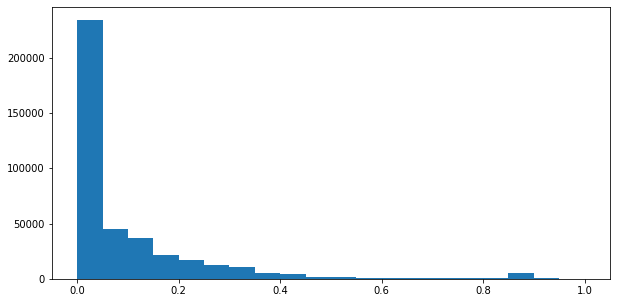

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

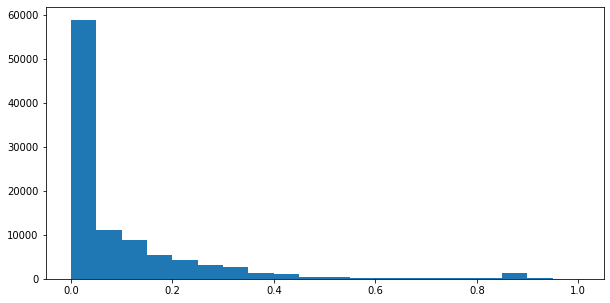

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'sigmoid'))
x.add(Dense(1024, activation = 'sigmoid'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         7755776     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 18s 21ms/step - loss: -0.4693 - manh_dist_loss: 0.0468 - abs_vect_loss: -0.9852 - abs_vect_1_loss: -0.9855 - manh_dist_rmse: 0.2164 - manh_dist_mae: 0.1358 - val_loss: -0.4831 - val_manh_dist_loss: 0.0241 - val_abs_vect_loss: -0.9903 - val_abs_vect_1_loss: -0.9903 - val_manh_dist_rmse: 0.1553 - val_manh_dist_mae: 0.1044
Epoch 2/20
781/781 [==============================] - 15s 19ms/step - loss: -0.4853 - manh_dist_loss: 0.0214 - abs_vect_loss: -0.9919 - abs_vect_1_loss: -0.9920 - manh_dist_rmse: 0.1463 - manh_dist_mae: 0.0982 - val_loss: -0.4860 - val_manh_dist_loss: 0.0202 - val_abs_vect_loss: -0.9922 - val_abs_vect_1_loss: -0.9922 - val_manh_dist_rmse: 0.1421 - val_manh_dist_mae: 0.0948
Epoch 3/20
781/781 [==============================] - 14s 18ms/step - loss: -0.4868 - manh_dist_loss: 0.0191 - abs_vect_loss: -0.9928 - abs_vect_1_loss: -0.9927 - manh_dist_rmse: 0.1381 - manh_dist_mae: 0.0931 - val_loss: -0.4872 - val_manh_dist_lo

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{Baseline}$

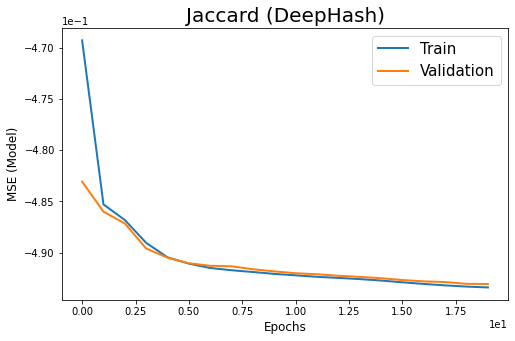

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('Jaccard (Baseline)', fontsize = 18)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of Similarity preserving loss

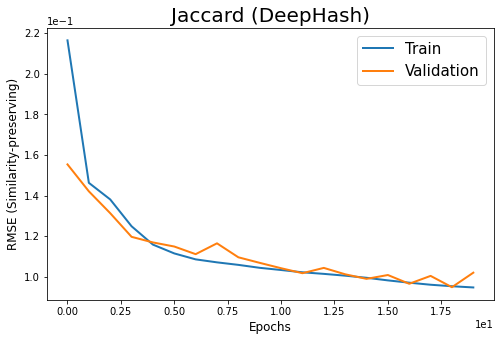

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Jaccard (Baseline)', fontsize = 18)
plt.ylabel('RMSE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

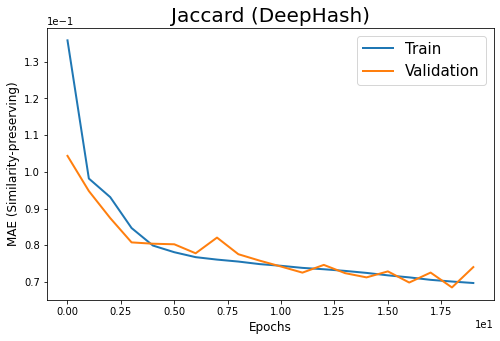

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Jaccard (Baseline)', fontsize = 20)
plt.ylabel('MAE (Similarity-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.063, 0.623, 0.021, 0.376, 0.07 , 0.099, 0.071, 0.205, 0.306,
       0.07 , 0.308, 0.195, 0.248, 0.214, 0.063, 0.089, 0.026, 0.383,
       0.981, 0.258, 0.022, 0.041, 0.024, 0.141, 0.068, 0.166, 0.063,
       0.058, 0.166, 0.057, 0.264, 0.69 , 0.035, 0.154, 0.031, 0.125,
       0.419, 0.058, 0.067, 0.531, 0.077, 0.041, 0.081, 0.034, 0.413,
       0.361, 0.038, 0.322, 0.066, 0.031], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.419, 0.   , 0.069, 0.   , 0.097, 0.   , 0.208, 0.28 ,
       0.073, 0.286, 0.   , 0.194, 0.208, 0.   , 0.   , 0.   , 0.379,
       0.875, 0.286, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.032, 0.143, 0.083, 0.065, 0.088, 0.   , 0.097, 0.   , 0.24 ,
       0.375, 0.   , 0.   , 0.364, 0.   , 0.   , 0.   , 0.   , 0.129,
       0.364, 0.   , 0.207, 0.069, 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

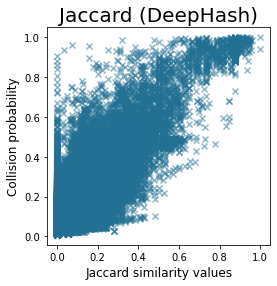

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Jaccard (Baseline)', fontsize = 20)
plt.xlabel("Jaccard similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Baseline/Jaccard-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.7442191764866607

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.5915171501556682

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-baseline.model')

INFO:tensorflow:Assets written to: Models/model-deep-hash.model/assets


In [33]:
#intermediate_model = keras.models.load_model('Models/model-baseline.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
'First 64 bits'
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:64]

array([-0.8982379 ,  0.9999993 , -0.99811006,  0.92509335,  0.88368213,
       -0.8427009 ,  0.83566105,  0.99999577, -0.9999995 ,  0.9999987 ,
       -0.8928796 ,  0.9999123 , -0.8130302 ,  0.8237904 , -0.9999997 ,
        0.90402865, -0.99998605, -0.99642867,  0.9999883 ,  0.9999989 ,
       -0.99985856, -0.99998933, -1.        ,  0.92533195, -0.99999875,
       -1.        , -0.8317841 , -0.99793226, -0.9982966 ,  0.89059186,
       -1.        , -0.9999149 ,  0.9107281 , -0.9999992 ,  0.99999654,
       -0.99993753,  0.8163208 ,  1.        ,  0.9999993 ,  0.9999757 ,
       -0.85498935,  0.9999889 , -0.89204586, -1.        ,  1.        ,
        0.99994755,  0.9999328 , -1.        , -0.99998957,  1.        ,
       -0.99998814, -0.99999917, -0.99999356,  0.9999982 ,  0.99996346,
       -0.99993545, -0.99995613,  0.8700783 , -1.        , -0.8031237 ,
       -0.9999977 ,  0.821039  , -0.99998105,  0.85695094], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [36]:
np.mean(np.abs(hash_vectors))

0.9250309

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [37]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.0929541015625

### 3.3.4. Comparison between approximate hamming and real hamming

In [38]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

In [39]:
df_hamming

,embedding_stack_1,embedding_stack_2,hamming
0,"[-1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1,...","[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, ...",0.046875
1,"[-1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, ...","[-1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, ...",0.875000
2,"[-1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1,...","[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, ...",0.000000
3,"[-1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1,...","[-1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1,...",0.359375
4,"[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, ...","[-1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, ...",0.000000
...,...,...,...
99895,"[-1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1, ...","[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1...",0.015625
99896,"[-1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1,...","[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, ...",0.031250
99897,"[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1...","[-1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, ...",0.015625
99898,"[-1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, ...","[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, ...",0.046875


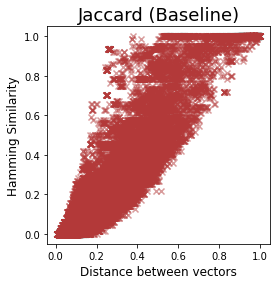

In [42]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Distance between vectors", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Jaccard (Baseline)', fontsize = 16)
plt.savefig('Results/Baseline/Jaccard-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [24]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [26]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)

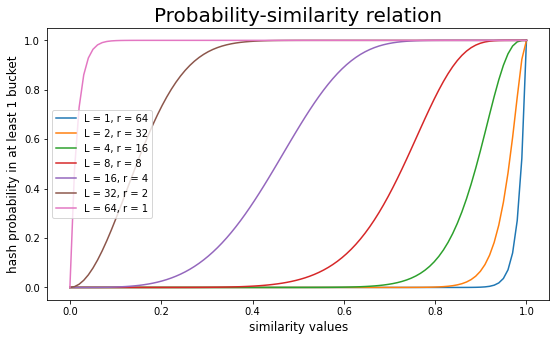

In [43]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 20)
plt.legend()

In [44]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Jaccard', trace = False)

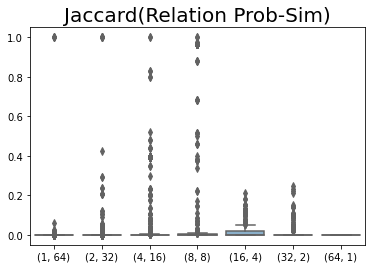

In [45]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.title('Jaccard(Relation Prob-Sim)', fontsize = 20)
plt.savefig('Results/Baseline/Jaccard-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [46]:
'L = K = 8'
L, K = params[3]
L, K

(8, 8)

### 4.1.1 Mean and Median probability for all stack traces for the best combination of $K$ and $L$

In [47]:
df_probLSH.mean()['(8, 8)']

0.1244768772958984

In [48]:
df_probLSH.median()['(8, 8)']

2.838930063209233e-05

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [49]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [50]:
with open('Hash-Tables/hash_tables_baseline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [51]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

812

In [52]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{62,
 68,
 100,
 135,
 148,
 150,
 169,
 180,
 192,
 215,
 260,
 273,
 284,
 285,
 289,
 297,
 318,
 338,
 340,
 378,
 393,
 414,
 423,
 424,
 445,
 454,
 455,
 457,
 468,
 478,
 487,
 523,
 563,
 595,
 673,
 697,
 702,
 733,
 734,
 735,
 787,
 812,
 853,
 857,
 888,
 917,
 921,
 977,
 979}

In [53]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [54]:
near_duplicates_sim = df_measures['Jaccard'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

346131    0.923077
464332    0.923077
363852    0.923077
446337    0.923077
244057    0.923077
481962    0.846154
481997    0.846154
481966    0.846154
164341    0.846154
306802    0.785714
404482    0.785714
60796     0.785714
247617    0.714286
334287    0.714286
482030    0.666667
482086    0.666667
464596    0.666667
358597    0.666667
174091    0.095238
417906    0.095238
281182    0.095238
282501    0.095238
482088    0.095238
267772    0.095238
455356    0.095238
126496    0.095238
315997    0.095238
253261    0.095238
328492    0.095238
482026    0.095238
236137    0.090909
192376    0.086957
95661     0.086957
476946    0.086957
464067    0.086957
137637    0.086957
139336    0.086957
453861    0.086957
351616    0.086957
66397     0.086957
226621    0.086957
244771    0.080000
333712    0.080000
155277    0.080000
352701    0.080000
386262    0.080000
351072    0.080000
368496    0.080000
Name: Jaccard, dtype: float64

In [55]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Jaccard', n_stacks, n_duplicate_pairs)
set_real_nns

{62,
 135,
 180,
 251,
 277,
 283,
 284,
 289,
 295,
 297,
 318,
 376,
 378,
 393,
 394,
 400,
 408,
 414,
 424,
 445,
 450,
 453,
 460,
 466,
 468,
 478,
 481,
 563,
 595,
 645,
 649,
 673,
 702,
 705,
 734,
 735,
 742,
 853,
 857,
 866,
 888,
 913,
 917,
 921,
 927,
 977,
 979,
 980}

In [56]:
real_nns_sim[:n_duplicate_pairs]

446337    0.923077
464332    0.923077
244057    0.923077
363852    0.923077
346131    0.923077
481962    0.846154
164341    0.846154
481966    0.846154
481997    0.846154
60796     0.785714
306802    0.785714
404482    0.785714
334287    0.714286
247617    0.714286
482030    0.666667
464596    0.666667
482086    0.666667
358597    0.666667
320211    0.388889
365409    0.388889
482089    0.350000
348886    0.333333
438237    0.277778
466416    0.222222
239031    0.111111
219934    0.105263
357534    0.100000
316602    0.095238
456241    0.095238
315997    0.095238
267772    0.095238
481975    0.095238
253261    0.095238
417906    0.095238
455356    0.095238
482022    0.095238
324967    0.095238
436831    0.095238
126496    0.095238
482036    0.095238
482026    0.095238
251856    0.095238
305559    0.095238
243342    0.095238
354321    0.095238
350527    0.095238
482088    0.095238
328492    0.095238
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [57]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard')

0.782

In [58]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard')

0.866734486266531

-----------------------------------------------------------------

In [59]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard')

0.7306666666666679

In [60]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard')

0.8308404558404565

-----------------------------------------------------------------

In [61]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard')

0.7105999999999999

In [62]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard')

0.8125142207053473

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [63]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

0.7480254230523627

In [64]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.824198
(2, 32)    0.803366
(4, 16)    0.735647
(8, 8)     0.658857
(16, 4)    0.663283
(32, 2)    0.830065
(64, 1)    0.990882
dtype: float64

In [65]:
df_knns.mean()['(8, 8)']

0.6588574533774387

In [27]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.015055
(2, 32)    0.010900
(4, 16)    0.068756
(8, 8)     0.275363
(16, 4)    0.317691
(32, 2)    0.509821
(64, 1)    0.558690
dtype: float64

In [30]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard', trace = False)
df_recall.mean(skipna = True)

(1, 64)    0.007282
(2, 32)    0.002301
(4, 16)    0.011715
(8, 8)     0.122845
(16, 4)    0.042298
(32, 2)    0.327974
(64, 1)    0.017880
dtype: float64